In [1]:
from __future__ import division, print_function
import numpy as np
from collections import OrderedDict
import logging

from IPython.display import display
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.wcs
from astropy import coordinates
import astropy.units as apu
from astropy import table

import astropyp
from astropyp.wrappers.astromatic import ldac
from astropyp.phot import stack
import bd_search

alogger = logging.getLogger('astropyp')
alogger.setLevel(logging.INFO)

idx_connect = 'sqlite:////media/data-beta/users/fmooleka/decam/decam.db'
ref_path = '/media/data-beta/users/fmooleka/decam/catalogs/ref/'

# SExtractor 'extract' detection parameters
conv_filter = np.load('/media/data-beta/users/fmooleka/2016decam/5x5gauss.npy')
sex_params = {
    'extract': {
        'thresh': 40,
        #'err':,
        'minarea': 3, # default
        'conv': conv_filter,
        #'deblend_nthresh': 32, #default
        'deblend_cont': 0.001,
        #'clean': True, #default
        #'clean_param': 1 #default
    },
    'kron_k': 2.5,
    'kron_min_radius': 3.5,
    'filter': conv_filter,
    #'thresh': 1.5 # *bkg.globalrms
}

obj='F100'
refname = '2MASS'
#refname = 'UCAC4'
fullref = ldac.get_table_from_ldac(ref_path+'{0}-{1}.fits'.format(obj, refname))

In [2]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

def get_exp_files(expnum, night, filtr, idx_connect):
    sql = 'select * from decam_obs where expnum={0} and filter like "{1}%" and dtcaldat="{2}"'.format(
        expnum, filtr, night)
    exp_info = astropyp.db_utils.index.query(sql, idx_connect)
    img_filename = exp_info[exp_info['PRODTYPE']=='image'][0]['filename']
    img = fits.open(img_filename)
    dqmask_filename = exp_info[exp_info['PRODTYPE']=='dqmask'][0]['filename']
    dqmask = fits.open(dqmask_filename)
    return img, dqmask
  
min_flux = 1000
min_amplitude = 1000
good_amplitude = 50
calibrate_amplitude = 200
frame = 1
#explist = [442430, 442431, 442432]
explist = [442433, 442434, 442435]
aper_radius = 8

ccds = []

for expnum in explist:
    #img, dqmask = get_exp_files(expnum, "2015-05-26", "i", idx_connect)
    img, dqmask = get_exp_files(expnum, "2015-05-26", "z", idx_connect)
    header = img[frame].header
    wcs = astropy.wcs.WCS(header)
    img_data = img[frame].data
    dqmask_data = dqmask[frame].data
    ccd = astropyp.phot.phot.SingleImage(header, img_data, dqmask_data,
        wcs=wcs, gain=4., exptime=30, aper_radius=aper_radius)
    ccds.append(ccd)

In [3]:
ccd_stack = stack.Stack(ccds, 1)
ccd_stack.detect_sources(min_flux=min_flux, good_amplitude=good_amplitude,
    calibrate_amplitude=calibrate_amplitude, psf_amplitude=1000, sex_params=sex_params, 
    subtract_bkg=True, windowed=False)

INFO:astropyp.phot.psf:Total sources: 1099
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 757
INFO:astropyp.phot.psf:Sources with bad pixels: 205
INFO:astropyp.phot.psf:Elliptical sources: 81
INFO:astropyp.phot.psf:Source with close neighbors: 230
INFO:astropyp.phot.psf:Sources near an edge: 18
INFO:astropyp.phot.psf:Sources after cuts: 200
INFO:astropyp.phot.psf:Total sources: 1024
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 733
INFO:astropyp.phot.psf:Sources with bad pixels: 181
INFO:astropyp.phot.psf:Elliptical sources: 72
INFO:astropyp.phot.psf:Source with close neighbors: 193
INFO:astropyp.phot.psf:Sources near an edge: 15
INFO:astropyp.phot.psf:Sources after cuts: 173
INFO:astropyp.phot.psf:Total sources: 1134
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 785
INFO:astropyp.phot.psf:Sources with bad pixels: 246
INFO:astropy

In [4]:
ccd_stack.get_transforms()

INFO:astropyp.phot.stack:(0, 1):{'rms': [0.099851245956758344, 0.097629656993243913], 'stddev': [0.099851245956758344, 0.097629656993243913], 'mean': [-1.3632453637540274e-12, 2.171576141632424e-12]}
INFO:astropyp.phot.stack:(2, 1):{'rms': [0.10342970807338657, 0.093860077693875124], 'stddev': [0.10342970807338657, 0.093860077693875124], 'mean': [1.0369422766395816e-12, 1.1939368548620508e-12]}
INFO:astropyp.phot.stack:(1, 0):{'rms': [0.099849912163565771, 0.097628988784096093], 'stddev': [0.099849912163565771, 0.097628988784096093], 'mean': [2.2487230780331642e-12, -8.487931323107079e-15]}
INFO:astropyp.phot.stack:(1, 2):{'rms': [0.10343371193592317, 0.093857402194311088], 'stddev': [0.10343371193592318, 0.093857402194311088], 'mean': [1.7209280757599604e-12, -2.7929795228723937e-13]}


In [5]:
result = ccd_stack.merge_catalogs(good_indices=[
        ccd_stack.ccds[n].indices['calibrate'] for n in ccd_stack.ccd_indices
    ], save_catalog=False)
print(len(result.sources))

INFO:astropyp.phot.stack:x rms: 0.0248209650904
INFO:astropyp.phot.stack:y rms: 0.0290018435794
INFO:astropyp.phot.stack:x rms: 0.00846591705474
INFO:astropyp.phot.stack:y rms: 0.00319670688603
INFO:astropyp.phot.stack:x rms: 0.0332868821448
INFO:astropyp.phot.stack:y rms: 0.0321985504659


554


In [6]:
result = ccd_stack.merge_catalogs(good_indices='good')
print(len(result.sources))

INFO:astropyp.phot.stack:x rms: 0.0284173497146
INFO:astropyp.phot.stack:y rms: 0.0958710107635
INFO:astropyp.phot.stack:x rms: 0.17380266757
INFO:astropyp.phot.stack:y rms: 0.184325140042
INFO:astropyp.phot.stack:x rms: 0.202220017284
INFO:astropyp.phot.stack:y rms: 0.0884541292784


754


In [5]:
result = ccd_stack.merge_catalogs()
print(len(ccd_stack.catalog.sources))

INFO:astropyp.phot.stack:x rms: 0.200749353379
INFO:astropyp.phot.stack:y rms: 0.0783453541869
INFO:astropyp.phot.stack:x rms: 0.0217314648602
INFO:astropyp.phot.stack:y rms: 0.0796414436288
INFO:astropyp.phot.stack:x rms: 0.22248081824
INFO:astropyp.phot.stack:y rms: 0.157986797816


1221


In [6]:
from astropyp.phot.stack import stack_source
def create_psf(self, aper_radius=None, method='mean', 
        create_catalog=True, good_indices=None, save_catalog=False,
        single_thread=False, pool_size=None, subsampling=None,
        max_offset=3, bad_pix_val=1):
    """
    Create a PSF from the psf sources in the ccd catalog. By default this
    will use multiprocessing to stack the sources as quickly as possible
    but this can be disabled.
    
    Parameters
    ----------
    aper_radius: float, optional
        Aperture radius to use for the psf. The default is to use the
        aperture radius set for the stack, and if that hasn't been set
        the aperture radius for the individual CCD's.
    method: string, optional
        This should be either 'median' or 'mean', describing how the
        individual images should be combined into the psf.
        *Default is 'mean'*
    create_catalog: bool
        Whether or not to create a catalog of psf stars.
        *Default=True*
    good_indices: string or list of arrays, optional
        If good_indices is a string, index ``ccd.indices[good_indices]``
        will be used for each CCD to filter the sources. Otherwise
        good_indices should be a list of indices to use for each CCD.
        If no god_indices are specified then all sources will be
        merged
    
    save_catalog: bool
        Whether or not to save the catalog
    
    Result
    ------
    psf: `~numpy.ndarray`
        Subpixel array with the psf for the stack
    """
    from astropyp.phot.psf import SinglePSF
    if aper_radius is None:
        if not hasattr(self, 'aper_radius'):
            if not hasattr(self.ccds[0], 'aper_radius'):
                raise ValueError("You must specify an aper_radius")
            else:
                self.aper_radius = self.ccds[0].aper_radius
        aper_radius = self.aper_radius
    if subsampling is None:
        if not hasattr(self, 'subsampling'):
            self.subsampling = self.ccds[0].subsampling
        subsampling = self.subsampling
    
    if method=='median':
        combine = np.ma.median
    elif method=='mean':
        combine = np.ma.mean
    else:
        raise ValueError("Method must be either 'median' or 'mean'")
    
    src_shape = (2*aper_radius+1, 2*aper_radius+1)
    
    if create_catalog:
        catalog = self.merge_catalogs(good_indices, save_catalog)
    elif self.catalog is not None:
        catalog = self.catalog
    else:
        raise Exception("You must create a catalog to create a psf")
    
    imgs = []
    dqmasks = []
    tx_solutions = []
    for n,ccd in enumerate(self.ccds):
        imgs.append(ccd.img)
        dqmasks.append(ccd.dqmask)
        if n!= self.ref_index:
            tx_solutions.append(self.tx_solutions[(self.ref_index, n)])
        else:
            tx_solutions.append(None)

    # Select sources that pass PSF cuts in all images
    psf_sources = catalog.sources
    print('psf sources', len(psf_sources))
    idx = np.zeros((len(psf_sources),), dtype=bool)
    for col in ['idx_'+str(n) for n in self.ccd_indices]:
        idx = idx | psf_sources[col].mask
    psf_sources = psf_sources[~idx]
    print('used psf sources', len(psf_sources))
    if single_thread:
        patches = []
        for src in psf_sources:
            data, dqmask = stack_source(imgs, src['x'], src['y'], 
                (src_shape[0]+2*max_offset,src_shape[1]+2*max_offset), 
                self.ref_index, tx_solutions, 
                dqmasks, subsampling=self.subsampling, 
                combine_method='mean', show_plots=False,
                bad_pix_val=bad_pix_val)
            data = data/np.max(data)
            patches.append(data)
    else:
        if pool_size is None:
            pool_size = multiprocessing.cpu_count()
            # Create a pool with the static (for all sources)
            # variables to speed up processing
            pool = multiprocessing.Pool(
                initializer=_init_multiprocess,
                initargs=(imgs, dqmasks, tx_solutions, src_shape,
                    self.ref_index, method, self.subsampling))
            src_coords = []
            for src in psf_sources:
                src_coords.append((src['x'], src['y']))
            result = pool.map(_multi_stack_worker, src_coords)
            patches, dqmasks = zip(*result)
            patches = [p/np.max(p) for p in patches]
            pool.close()
            pool.join()
    for n, patch in enumerate(patches):
        src_pos = (int(patch.shape[0]*.5),int(patch.shape[1]*.5))
        patches[n], X, Y, new_pos = astropyp.utils.misc.get_subpixel_patch(
            patch, src_pos, (src_shape[0]*subsampling, src_shape[1]*subsampling), max_offset, subsampling=1)
    psf_array = np.ma.array(patches)
    psf_array = combine(psf_array, axis=0)
    
    # Add a mask to hide values outside the aperture radius
    if not hasattr(self, 'subsampling'):
        self.subsampling = self.ccds[0].subsampling
    radius = aper_radius*self.subsampling
    ys, xs = psf_array.shape
    yc,xc = (np.array([ys,xs])-1)/2
    y,x = np.ogrid[-yc:ys-yc, -xc:xs-xc]
    mask = x**2+y**2<=radius**2
    circle_mask = np.ones(psf_array.shape)
    circle_mask[mask]=0
    circle_mask
    psf_array = np.ma.array(psf_array, mask=circle_mask)
    self.psf = SinglePSF(psf_array, 1., 0, 0, self.subsampling)
    return self.psf

INFO:astropyp.phot.stack:x rms: 0.0674731673014
INFO:astropyp.phot.stack:y rms: 0.0188879073924
INFO:astropyp.phot.stack:x rms: 0.17403721731
INFO:astropyp.phot.stack:y rms: 0.0645115064397
INFO:astropyp.phot.stack:x rms: 0.106564050009
INFO:astropyp.phot.stack:y rms: 0.0833994138325


psf sources 218
used psf sources 160


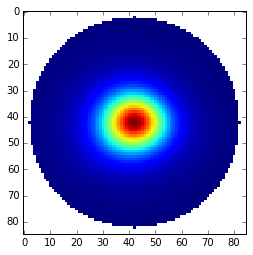

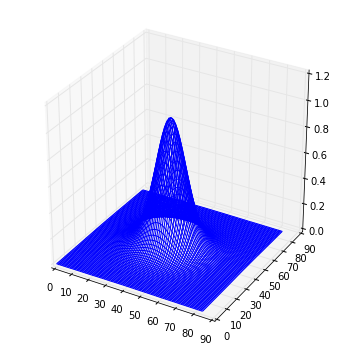

In [44]:
#psf = ccd_stack.create_psf(good_indices='psf', create_catalog=True, 
psf = create_psf(ccd_stack, good_indices='psf', create_catalog=True, 
    method='median', single_thread=True, max_offset=3, save_catalog=True)
psf = psf._psf_array
plt.imshow(psf, interpolation='none')
plt.show()
from mpl_toolkits.mplot3d.axes3d import Axes3D
X = np.arange(0,psf.shape[1], 1)
Y = np.arange(0,psf.shape[0], 1)
Xmesh, Ymesh = np.meshgrid(X, Y)
fig = plt.figure(figsize=(6, 6))
ax=fig.add_subplot(1,1,1, projection='3d')
ax.plot_wireframe(Xmesh, Ymesh, psf)
plt.show()

In [46]:
def perform_psf_photometry(self, separation=None, 
        verbose=False, fit_position=True, pos_range=0, indices=None,
        kd_tree=None, exptime=None, pool_size=None, stack_method='mean',
        save_catalog=True, single_thread=False):
    """
    Perform PSF photometry on all of the sources in the catalog,
    or if indices is specified, a subset of sources.

    Parameters
    ----------
    separation: float, optional
        Separation (in pixels) for members to be considered
        part of the same group *Default=1.5*psf width*
    verbose: bool, optional
        Whether or not to show info about the fit progress.
        *Default=False*
    fit_position: bool, optional
        Whether or not to fit the position along with the
        amplitude of each source. *Default=True*
    pos_range: int, optional
        Maximum number of pixels (in image pixels) that
        a sources position can be changed. If ``pos_range=0``
        no bounds will be set. *Default=0*
    indices: `~numpy.ndarray` or string, optional
        Indices for sources to calculate PSF photometry.
        It is often advantageous to remove sources with
        bad pixels and sublinear flux to save processing time.
        All sources not included in indices will have their
        psf flux set to NaN. This can either be an array of
        indices for the positions in self.catalog or 
        the name of a saved index in self.indices
    """
    import astropyp.catalog
    from astropyp.phot.psf import SinglePSF
    
    # If no exposure time was passed to the stack and all of the
    # ccds had the same exposure time, use that to calcualte the
    # psf magnitude
    if exptime is None:
        if hasattr(self, 'exptime'):
            exptime = self.exptime
        else:
            same_exptime = True
            exptime = np.nan
            for ccd in self.ccds:
                if np.isnan(exptime):
                    exptime = ccd.exptime
                elif ccd.exptime != exptime:
                    same_exptime = False
            if not same_exptime:
                exptime = None
    
    if hasattr(self.catalog, 'peak'):
        peak = self.catalog.peak
    else:
        from astropyp.utils.misc import update_ma_idx
        peak = [
            update_ma_idx(self.ccds[n].catalog['peak'],
            self.catalog['idx_'+str(n)]) 
                for n in self.ccd_indices]
        peak = np.ma.mean(peak, axis=0)
    src_shape = (2*self.aper_radius+1, 2*self.aper_radius+1)
    
    # Get the positions and estimated amplitudes of
    # the sources to fit
    
    if indices is not None:
        positions = zip(self.catalog.x[indices], 
                        self.catalog.y[indices])
        amplitudes = peak[indices]
    else:
        positions = zip(self.catalog.x, self.catalog.y)
        amplitudes = peak

    src_count = len(positions)

    src_indices = np.arange(0,len(self.catalog.sources),1)
    all_positions = np.array(zip(self.catalog.x, self.catalog.y))
    all_amplitudes = peak
    total_sources = len(all_amplitudes)
    src_psfs = []

    psf_flux = np.ones((total_sources,))*np.nan
    psf_flux_err = np.ones((total_sources,))*np.nan
    psf_x = np.ones((total_sources,))*np.nan
    psf_y = np.ones((total_sources,))*np.nan
    new_amplitudes = np.ones((total_sources,))*np.nan

    # Find nearest neighbors to avoid contamination by nearby sources
    if separation is not None:
        if not hasattr(self, 'kdtree'):
            from scipy import spatial
            KDTree = spatial.cKDTree
            self.kd_tree = KDTree(all_positions)
        idx, nidx = astropyp.catalog.find_neighbors(separation, 
            kd_tree=self.kd_tree)
    # Get parameters to pass to the pool manager
    imgs = []
    dqmasks = []
    tx_solutions = []
    for n,ccd in enumerate(self.ccds):
        imgs.append(ccd.img)
        dqmasks.append(ccd.dqmask)
        if n!= self.ref_index:
            tx_solutions.append(self.tx_solutions[(self.ref_index, n)])
        else:
            tx_solutions.append(None)
    residuals=[]
    if single_thread:
        for n in range(len(positions))[:5]:
            if indices is not None:
                src_idx = src_indices[indices][n]
            else:
                src_idx = src_indices[n]
            if separation is not None:
                n_indices = nidx[idx==src_idx]
                neighbor_positions = all_positions[n_indices]
                neighbor_amplitudes = all_amplitudes[n_indices]
            else:
                neighbor_positions = []
                neighbor_amplitudes = []
            
            patch, dqmask = stack_source(imgs, positions[n][0], 
                positions[n][1], src_shape, self.ref_index, tx_solutions, 
                dqmasks, combine_method='mean', show_plots=False,
                subsampling=self.subsampling)
            print('max', np.max(patch))
            if patch is not None:
                # Perform PSF phot on the stacked source
                src_psf = SinglePSF(self.psf._psf_array, 
                    amplitudes[n], positions[n][0], positions[n][1],
                    subsampling=self.subsampling,
                    neighbor_positions=neighbor_positions,
                    neighbor_amplitudes=neighbor_amplitudes)
                
                psf_flux[src_idx], psf_flux_err[src_idx], residual, new_pos = \
                    src_psf.fit(patch, patch=patch)
                new_amplitudes[src_idx] = src_psf.amplitude.value
                print(src_psf.amplitude.value)
                psf_x[src_idx], psf_y[src_idx] = new_pos
                residuals.append(residual)
    else:
        if pool_size is None:
            pool_size = multiprocessing.cpu_count()
        # Create a pool with the static (for all sources)
        # variables to speed up processing
        pool = multiprocessing.Pool(
            processes=pool_size,
            initializer=_init_multiprocess,
            initargs=(imgs, dqmasks, tx_solutions, src_shape,
                self.ref_index, stack_method, self.subsampling, 
                self.psf))
        pool_args = []
        # Fit each source to the PSF, calcualte its flux, and its new
        # position
        for n in range(len(positions)):
            if indices is not None:
                src_idx = src_indices[indices][n]
            else:
                src_idx = src_indices[n]
            if separation is not None:
                n_indices = nidx[idx==src_idx]
                neighbor_positions = all_positions[n_indices]
                neighbor_amplitudes = all_amplitudes[n_indices]
            else:
                neighbor_positions = []
                neighbor_amplitudes = []
            pool_args.append((amplitudes[n], 
                (positions[n][1], positions[n][0]),
                self.subsampling,
                neighbor_positions,
                neighbor_amplitudes))

        result = pool.map(_stack_psf_worker, pool_args)
        pool.close()
        pool.join()
        # Update the various psf array parameters
        for n in range(len(positions)):
            if indices is not None:
                src_idx = src_indices[indices][n]
            else:
                src_idx = src_indices[n]
            psf_flux[src_idx] = result[n][0]
            psf_flux_err[src_idx] = result[n][1]
            new_amplitudes[src_idx] = result[n][2]
            psf_x[src_idx], psf_y[src_idx] = result[n][3]

    # Save the psf derived quantities in the catalog
    # Ignore divide by zero errors that occur when sources
    # have zero psf flux (i.e. bad sources)
    if save_catalog:
        np_err = np.geterr()
        np.seterr(divide='ignore')
        self.catalog.sources['psf_flux'] = psf_flux
        self.catalog.sources['psf_flux_err'] = psf_flux_err
        if exptime is not None:
            psf_mag = -2.5*np.log10(psf_flux/exptime)
            self.catalog.sources['psf_mag'] = psf_mag
            self.catalog.sources['psf_mag_err'] = psf_flux_err/psf_flux
        self.catalog.sources['psf_x'] = psf_x
        self.catalog.sources['psf_y'] = psf_y
        np.seterr(**np_err)
    
    return psf_flux, psf_flux_err, residuals, new_amplitudes

In [47]:
result = ccd_stack.merge_catalogs(good_indices='psf')
print(len(result.sources))

INFO:astropyp.phot.stack:x rms: 0.0674731673014
INFO:astropyp.phot.stack:y rms: 0.0188879073924
INFO:astropyp.phot.stack:x rms: 0.17403721731
INFO:astropyp.phot.stack:y rms: 0.0645115064397
INFO:astropyp.phot.stack:x rms: 0.106564050009
INFO:astropyp.phot.stack:y rms: 0.0833994138325


218


In [48]:
np.max(ccd_stack.psf._psf_array)

1.0017434067657853

In [49]:
patch, dqmask, residuals, peaks = perform_psf_photometry(ccd_stack, single_thread=True)

max 1972.40279181
3482.35867911
max 11281.7365298
19872.4077142
max 3245.02600362
5706.98400548
max 1386.75400082
2416.67184445
max 1294.23757318
2444.60804663


max 784.602228477 min -1497.78618919


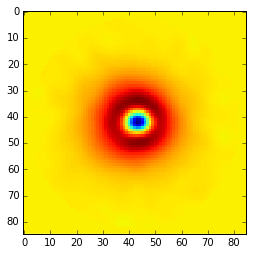

max 4232.92015347 min -8485.74519951


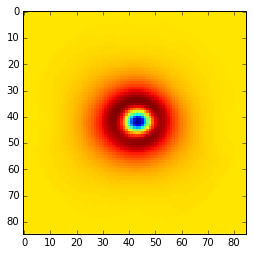

max 1222.61104144 min -2454.53546958


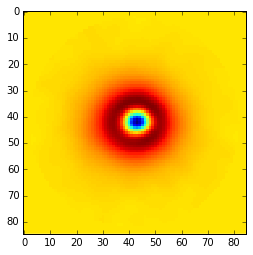

max 525.462028544 min -1014.98737157


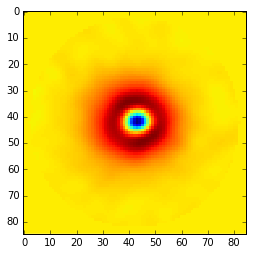

max 707.297835678 min -1136.15331291


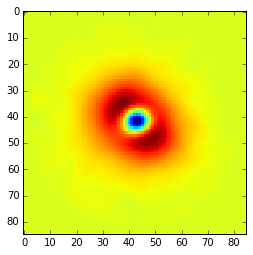

In [50]:
for n in range(5):
    print('max', np.max(residuals[n]), 'min', np.min(residuals[n]))
    plt.imshow(residuals[n], interpolation='none')
    plt.show()

In [59]:
#good_idx = ccd_stack.catalog.sources['peak']>calibrate_amplitude
#good_idx = good_idx & (ccd_stack.catalog.sources['pipeline_flags']==0)
#good_idx = good_idx & np.isfinite(ccd_stack.catalog.sources['psf_mag'])
good_sources = ccd_stack.catalog.sources[np.isfinite(ccd_stack.catalog.sources['psf_mag'])]

print('rms', np.sqrt(np.sum(good_sources['psf_mag_err']**2/len(good_sources))))
print('mean', np.mean(good_sources['psf_mag_err']))
print('median', np.median(good_sources['psf_mag_err']))
print('stddev', np.std(good_sources['psf_mag_err']))

bad_count = np.sum(good_sources['psf_mag_err']>.05)
print('bad psf error: {0}, or {1}%'.format(bad_count, bad_count/len(good_sources)*100))
print('Better than 5%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.05), len(good_sources)))
print('Better than 2%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.02), len(good_sources)))

rms 0.361270916539
mean 0.358834469477
median 0.336229603065
stddev 0.0418867359916
bad psf error: 5, or 100.0%
Better than 5%: 0 of 5
Better than 2%: 0 of 5


INFO:astropyp.phot.stack:x rms: 0.0674731673014
INFO:astropyp.phot.stack:y rms: 0.0188879073924
INFO:astropyp.phot.stack:x rms: 0.17403721731
INFO:astropyp.phot.stack:y rms: 0.0645115064397
INFO:astropyp.phot.stack:x rms: 0.106564050009
INFO:astropyp.phot.stack:y rms: 0.0833994138325


('psf sources', 218)


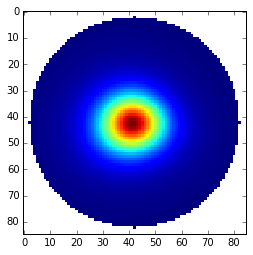

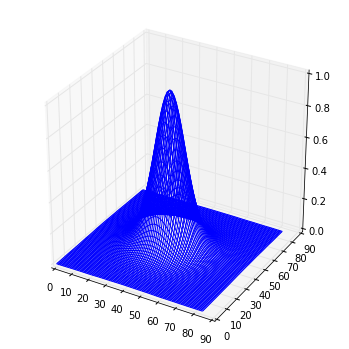

In [9]:
psf = ccd_stack.create_psf(good_indices='psf', single_thread=True)
plt.imshow(psf, interpolation='none')
plt.show()
from mpl_toolkits.mplot3d.axes3d import Axes3D
X = np.arange(0,psf.shape[1], 1)
Y = np.arange(0,psf.shape[0], 1)
Xmesh, Ymesh = np.meshgrid(X, Y)
fig = plt.figure(figsize=(6, 6))
ax=fig.add_subplot(1,1,1, projection='3d')
ax.plot_wireframe(Xmesh, Ymesh, psf)
plt.show()

In [ ]:
#src_idx = 0 # peak = 162
#src_idx = 2 # peak = 2000
#src_idx = 3 # peak = 11000
src_idx = 8 # peak = 536
#src_idx = 11 # peak = 267
#src_idx = 641 # peak=71
#src_idx = 471 # peak=99

src = ccd_stack.catalog.sources[src_idx]
src_shape = (2*aper_radius+1, 2*aper_radius+1)
imgs = [ccd.img for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)],None,ccd_stack.tx_solutions[(1,2)]]
data, dqmask = stack.stack_source(imgs, src['x_1'], src['y_1'], src_shape, 1, tx_solutions, 
                    dqmasks, combine_method='mean', show_plots=False)
plt.imshow(dqmask, interpolation='none')
plt.show()
plt.imshow(data, interpolation='none')
plt.show()

In [ ]:
cat0 = ccds[442433].catalog.sources
cat1 = ccds[442434].catalog.sources
cat2 = ccds[442435].catalog.sources

#src0 = cat0[cat0['pipeline_flags']>=128][6]
src0 = cat0[cat0['pipeline_flags']>=128][3]
print(src0['y'], src0['x'])

c0 = coordinates.SkyCoord([src0['ra']],[src0['dec']], unit='deg')
c1 = coordinates.SkyCoord(cat1['ra'],cat1['dec'], unit='deg')
c2 = coordinates.SkyCoord(cat2['ra'],cat2['dec'], unit='deg')

idx1, d2, d3 = c0.match_to_catalog_sky(c1)
idx1 = idx1[0]
idx2, d2, d3 = c0.match_to_catalog_sky(c2)
idx2 = idx2[0]

# Get the patch from the original image
src1 = cat1[idx1]
src2 = cat2[idx2]
print(src1['y'],src1['x'])
print(src2['y'],src2['x'])

src_shape = (2*aper_radius+1, 2*aper_radius+1)
data, dqmask = stack.stack_source(imgs, src1['x'], src1['y'], src_shape, 1, tx_solutions, 
                    dqmasks, combine_method='mean', show_plots=True)

In [ ]:
cat0 = ccds[442433].catalog.sources
cat1 = ccds[442434].catalog.sources
cat2 = ccds[442435].catalog.sources

src0 = cat0[cat0['pipeline_flags']>=128][6]
#src0 = cat0[cat0['pipeline_flags']>=128][3]
print(src0['y'], src0['x'])

c0 = coordinates.SkyCoord([src0['ra']],[src0['dec']], unit='deg')
c1 = coordinates.SkyCoord(cat1['ra'],cat1['dec'], unit='deg')
c2 = coordinates.SkyCoord(cat2['ra'],cat2['dec'], unit='deg')

idx1, d2, d3 = c0.match_to_catalog_sky(c1)
idx1 = idx1[0]
idx2, d2, d3 = c0.match_to_catalog_sky(c2)
idx2 = idx2[0]

# Get the patch from the original image
src1 = cat1[idx1]
src2 = cat2[idx2]
print(src1['y'],src1['x'])
print(src2['y'],src2['x'])

src_shape = (2*aper_radius+1, 2*aper_radius+1)
data, dqmask = stack.stack_source(imgs, src1['x'], src1['y'], src_shape, 1, tx_solutions, 
                    dqmasks, combine_method='mean', show_plots=True)

In [ ]:
cat0 = ccds[442433].catalog.sources
cat1 = ccds[442434].catalog.sources
cat2 = ccds[442435].catalog.sources

src0 = cat0[cat0['pipeline_flags']>=128][0]
print(src0['y'], src0['x'])

c0 = coordinates.SkyCoord([src0['ra']],[src0['dec']], unit='deg')
c1 = coordinates.SkyCoord(cat1['ra'],cat1['dec'], unit='deg')
c2 = coordinates.SkyCoord(cat2['ra'],cat2['dec'], unit='deg')

idx1, d2, d3 = c0.match_to_catalog_sky(c1)
idx1 = idx1[0]
idx2, d2, d3 = c0.match_to_catalog_sky(c2)
idx2 = idx2[0]

# Get the patch from the original image
src1 = cat1[idx1]
src2 = cat2[idx2]
print(src1['y'],src1['x'])
print(src2['y'],src2['x'])

src_shape = (2*aper_radius+1, 2*aper_radius+1)
data, dqmask = stack.stack_source(imgs, src1['x'], src1['y'], src_shape, 1, tx_solutions, 
                    dqmasks, combine_method='mean', show_plots=True)
print(data, dqmask)

In [ ]:
all_ra = [cat1['ra_win'], cat2['ra_win'], cat3['ra_win']]
all_dec = [cat1['dec_win'], cat2['dec_win'], cat3['dec_win']]
ra, dec = astropyp.catalog.combine_coordinates(all_ra, all_dec, method='median')
cc = table.Table([ra, dec, cat1['xwin'], cat1['ywin'], cat1['peak']], names=('ra','dec','x','y', 'peak'))

good_cat = astropyp.catalog.Catalog(cc)
refcat = astropyp.catalog.Catalog(fullref)
metric = astropyp.astrometry.AstrometricSolution()

ref_weights = 1/np.sqrt(refcat.e_ra**2+refcat.e_dec**2)

idx, matched = metric.get_solution(good_cat, refcat, ref_weights=ref_weights)
#idx, matched = metric.get_solution(good_cat, refcat, separation=3*apu.arcsec)

ra,dec = metric.pix2world(good_cat.x[matched],good_cat.y[matched])
d_ra = ((np.abs(ra-np.array(refcat.ra[idx][matched]))*np.cos(np.deg2rad(np.array(dec))))*apu.deg).to('mas')
d_dec = ((np.abs(dec-np.array(refcat.dec[idx][matched])))*apu.deg).to('mas')
print 'mean d_ra', np.mean(d_ra)
print 'mean d_dec', np.mean(d_dec)
print 'ra rms', np.sqrt(np.sum(d_ra**2)/d_ra.shape[0])
print 'dec rms', np.sqrt(np.sum(d_dec**2)/d_dec.shape[0])

c1 = coordinates.SkyCoord(ra, dec, unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched], refcat.dec[idx][matched], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print np.mean(separation)
print np.std(separation)
print 'rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

pidx = good_cat['peak'][matched]>1000
c1 = coordinates.SkyCoord(ra[pidx], dec[pidx], unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched][pidx], refcat.dec[idx][matched][pidx], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print 'high SNR sources', np.sum(pidx)
print 'high SNR', np.mean(separation)
print 'high SNR', np.std(separation)
print 'high SNR rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

x,y = metric.world2pix(ra, dec)
d2 = np.sqrt((x-good_cat.x[matched])**2 + (y-good_cat.y[matched])**2)
print 'cartesian mean', np.mean(d2)
print 'cartesian stddev', np.std(d2)
print 'cartesian rms', np.mean(d2)+np.std(d2)

In [ ]:
good_cat = astropyp.catalog.Catalog(cat1, ra='ra_win', dec='dec_win', x='xwin',y='ywin')
refcat = astropyp.catalog.Catalog(fullref)
metric = astropyp.astrometry.AstrometricSolution()

ref_weights = 1/np.sqrt(refcat.e_ra**2+refcat.e_dec**2)

idx, matched = metric.get_solution(good_cat, refcat, ref_weights=ref_weights)
#idx, matched = metric.get_solution(good_cat, refcat, separation=3*apu.arcsec)

ra,dec = metric.pix2world(good_cat.x[matched],good_cat.y[matched])

c1 = coordinates.SkyCoord(ra, dec, unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched], refcat.dec[idx][matched], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print np.mean(separation)
print np.std(separation)
print 'rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

#pidx = good_cat['peak'][matched]>2000
pidx = good_cat['aper_flux'][matched]/good_cat['aper_flux_err'][matched]>100
c1 = coordinates.SkyCoord(ra[pidx], dec[pidx], unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched][pidx], refcat.dec[idx][matched][pidx], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print 'high SNR sources', np.sum(pidx)
print 'high SNR', np.mean(separation)
print 'high SNR', np.std(separation)
print 'high SNR rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

x,y = metric.world2pix(ra, dec)
d2 = np.sqrt((x-good_cat.x[matched])**2 + (y-good_cat.y[matched])**2)
print 'cartesian mean', np.mean(d2)
print 'cartesian stddev', np.std(d2)
print 'cartesian rms', np.sqrt(np.sum(d2**2)/d2.shape[0])

In [ ]:
referr = np.sqrt(fullref['e_ra']**2 + fullref['e_dec']**2)
print np.mean(referr)
print np.std(referr)
print np.sqrt(np.sum(referr**2)/referr.shape[0])

In [ ]:
pidx = good_cat['aper_flux'][matched]/good_cat['aper_flux_err'][matched]>100
c1 = coordinates.SkyCoord(good_cat['ra'][matched][pidx], good_cat['dec'][matched][pidx], unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched][pidx], refcat.dec[idx][matched][pidx], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print 'high SNR sources', np.sum(pidx)
print 'high SNR', np.mean(separation)
print 'high SNR', np.std(separation)
print 'high SNR rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

In [ ]:
sql = 'select * from decam_obs where expnum={0}'.format(206392)
astropyp.db_utils.index.query(sql, idx_connect)